In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from numba import jit
import seaborn as sns
from collections import defaultdict
import numpy as np

## Import train and test data

In [3]:
iris_train = pd.read_csv("data/iris_train.data", 
                         names = ["sepal_length","sepal_width","petal_length",
                                  "petal_width","label"])
iris_test = pd.read_csv("data/iris_test.data",
                        names = ["sepal_length","sepal_width",
                                 "petal_length","petal_width","label"])

## Z-transformer

In [4]:
class Transformation(object):
    def __init__(self, df_train):
        self.cols_stats = defaultdict(lambda: {})
        cols = list(df_train.columns)
        cols.remove("label")
        self.cols = cols
        for col in cols:
            self.cols_stats[col]['mean'] = df_train[col].mean()
            self.cols_stats[col]['std'] = df_train[col].std(ddof=0)
        
    def transform(self, df_orig):
        df = df_orig.copy(deep = True)
        for col in self.cols:
            df[col] = (df[col] - self.cols_stats[col]['mean']) / self.cols_stats[col]['std']
        return df        

In [5]:
trans = Transformation(iris_train)
iris_train_z = trans.transform(iris_train)
iris_test_z = trans.transform(iris_test)

## 2D Scatter plots of features (original)

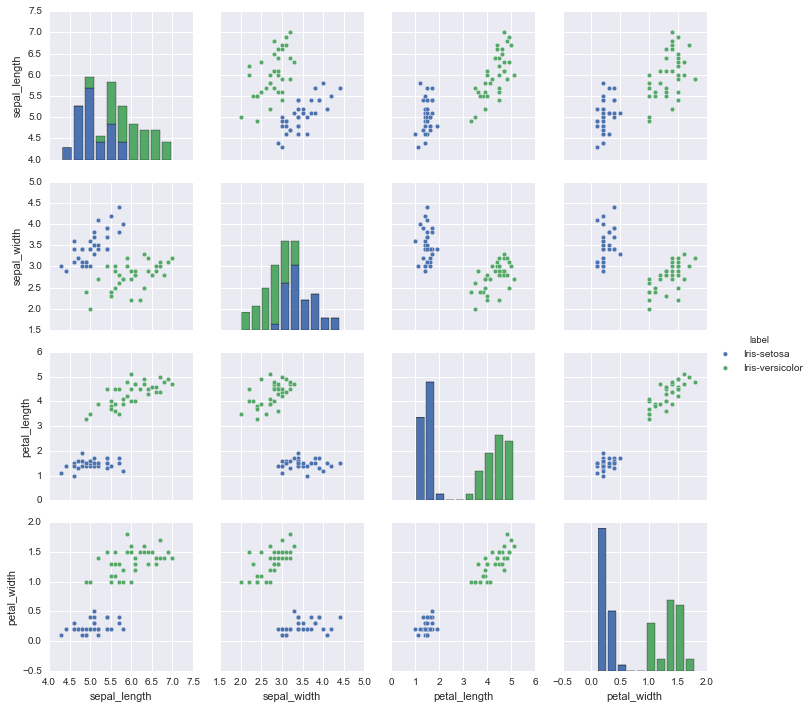

In [6]:
sns.pairplot(iris_train, hue="label")

### After Z-transformation

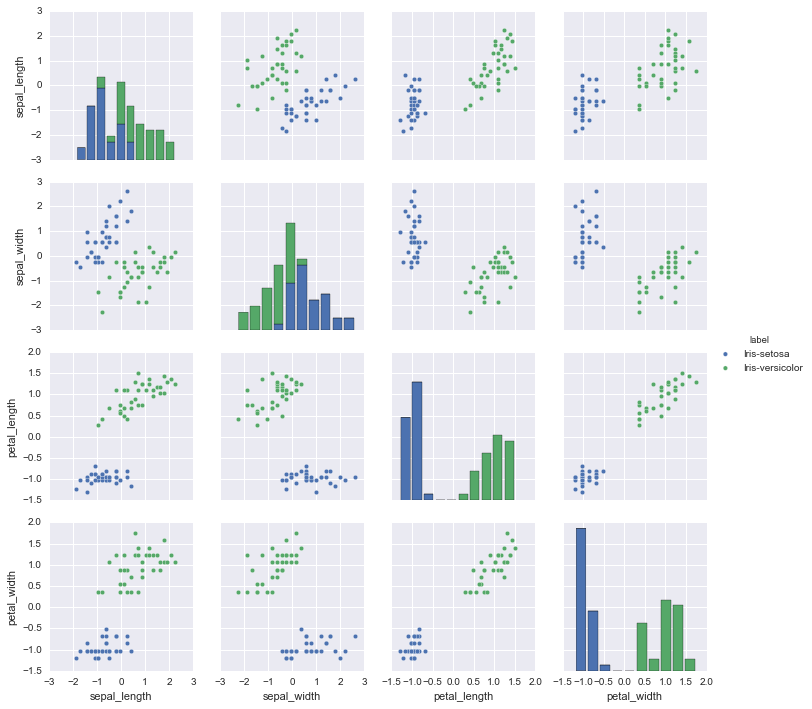

In [7]:
sns.pairplot(iris_train_z, hue="label")

## Perceptron class

In [8]:
class Perceptron(object):
    def __init__(self, df_train, df_test, label = "label", 
                 max_iterations = 5, eta = 1):
        self.df_train = df_train.copy(deep = True)
        self.df_test = df_test.copy(deep = True)
        self.target =  np.array(self.df_train.label == "Iris-setosa")
        self.max_iterations = max_iterations
        self.eta = eta
        self.predictors = list(self.df_train.columns)
        self.predictors.remove(label)
        np.random.seed(2)
        self.weights = np.random.rand(len(self.predictors) + 1) * 2 - 1
        self.df_train.drop('label', axis=1, inplace=True)
        self.df_test['label'] = self.df_test['label'] == "Iris-setosa"
        
    def response(self, x):
        y = self.weights.dot(x)
        return 1 if y >= 0 else 0

    def train(self):
        stop = False
        iterations = 0
        while not stop:
            for index, row in self.df_train.iterrows():
                input = np.append(np.array(row), 1)
                self.weights += self.eta * (self.target[index] - self.response(input)) * input
            print "Epoch %s: Test error: %s " % (iterations+1,self.test_error())
            iterations += 1
            if iterations > self.max_iterations:
                stop = True
            
    def test_error(self):
        predictions = []
        for index, row in self.df_test.iterrows():
            input = np.append(np.array(row[:4]), 1)
            predictions.append(self.response(input))
        error = sum(predictions != self.df_test.label)
        return error * 1.0 / len(self.df_test)
        

## Define the perceptron class

In [9]:
clf = Perceptron(iris_train_z, iris_test_z)

## Train the perceptron

In [10]:
clf.train()

Epoch 1: Test error: 0.0 
Epoch 2: Test error: 0.0 
Epoch 3: Test error: 0.0 
Epoch 4: Test error: 0.0 
Epoch 5: Test error: 0.0 
Epoch 6: Test error: 0.0 


## Final perceptron weights

In [11]:
clf.weights

array([ 0.17558603,  1.29549211, -1.20083989, -1.51792913, -0.1592644 ])

Note: Last term above is the "bias" term.

### Training the perceptron without Z-scoring

In [12]:
clf2 = Perceptron(iris_train, iris_test)

In [13]:
clf2.train()

Epoch 1: Test error: 0.5 
Epoch 2: Test error: 0.5 
Epoch 3: Test error: 0.0 
Epoch 4: Test error: 0.0 
Epoch 5: Test error: 0.0 
Epoch 6: Test error: 0.0 


In [14]:
clf2.weights

array([ 1.1719898 ,  3.15185246, -5.10067504, -2.32935521,  0.8407356 ])